In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
# from PIL import Image

from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer

import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from transformers import AutoTokenizer, AutoModel
from torch import no_grad, cat, device, cuda
from torch.utils.data import DataLoader, Dataset

from spellchecker import SpellChecker
from multiprocessing import cpu_count

from functools import lru_cache
from dask import dataframe as dd

nltk.download('stopwords')
sw = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Richa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Funções

In [2]:
# código para remover símbolos e palavras de conexão
def remover_simbolos_numeros_stopwords(texto):
    apenas_letras = re.sub(r'[^A-Za-z\s]', '', texto).lower()
    sem_espacos_duplos = re.sub(r'\s+', ' ', apenas_letras).strip()
    return ' '.join([palavra for palavra in sem_espacos_duplos.split(" ") if palavra not in sw])

In [3]:
##codigo para agrupar nomes parecidos de empreendimentos
def agrupar_nomes(nomes, threshold=100):
    agrupados = {}
    for nome in nomes:
        encontrado = False
        for chave in agrupados.keys():
            if fuzz.token_sort_ratio(nome, chave) > threshold:
                agrupados[chave].append(nome)
                encontrado = True
                break
        if not encontrado:
            agrupados[nome] = [nome]
    return agrupados

In [4]:
class SentenceDataset(Dataset):
    def __init__(self, sentences, tokenizer):
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        inputs = self.tokenizer(sentence, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
        return inputs

In [5]:
# Função para obter embeddings usando DataLoader
def get_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    with no_grad():
        for batch in dataloader:
            inputs = {k: v.squeeze(1).to(model.device) for k, v in batch.items()}
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu())
    return cat(embeddings)


In [34]:
# Função para corrigir palavras com cache
@lru_cache#(maxsize=1024)
def corrigir_palavra(palavra):
    if spell.candidates(palavra):
        return spell.correction(palavra)
    return palavra

# Importações

In [8]:
df_empreend = pd.read_csv('../dados/simu-carteira-mun-T.csv')

#Tabela de palavras obtido ao executar o código corretor de erro com duração > 5h
df_salvo = pd.read_csv('../dados/teste_empreendimentos_codigo_corretor.csv')
df_salvo

C:\Users\Richa\AppData\Local\Temp\ipykernel_25192\1503222987.py:1: DtypeWarning: Columns (9,42,61,75,77,78,79,86,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df_empreend = pd.read_csv('../dados/simu-carteira-mun-T.csv')


,Unnamed: 0,palavras,palavras_corrigidas
0,0,implantacao,implantado
1,0,rapido,rápido
2,0,onibus,ónibus
3,0,v,a
4,0,caxanga,capanga
...,...,...,...
23649,66732,trasnportes,transportes
23650,66733,otima,ótima
23651,66733,tranportes,transportes
23652,66734,ccb,com


In [9]:
df_salvo['palavras_corrigidas'].value_counts()

a                 58
de                46
município         39
infraestrutura    35
para              33
                  ..
ordem              1
mundonovo          1
derivado           1
delito             1
aqusicao           1
Name: palavras_corrigidas, Length: 17552, dtype: int64

Tratando essas palavras retornadas

In [10]:
df_salvo['aux_palavras'] = df_salvo['palavras_corrigidas'].apply(lambda x: remover_simbolos_numeros_stopwords(x))
df_salvo['aux_palavras'].value_counts()

                       807
municpio                39
infraestrutura          35
drenagem                31
sarjeta                 25
                      ... 
cabecdirponte            1
deekeeavcomunidades      1
verter                   1
schlegel                 1
aqusicao                 1
Name: aux_palavras, Length: 17423, dtype: int64

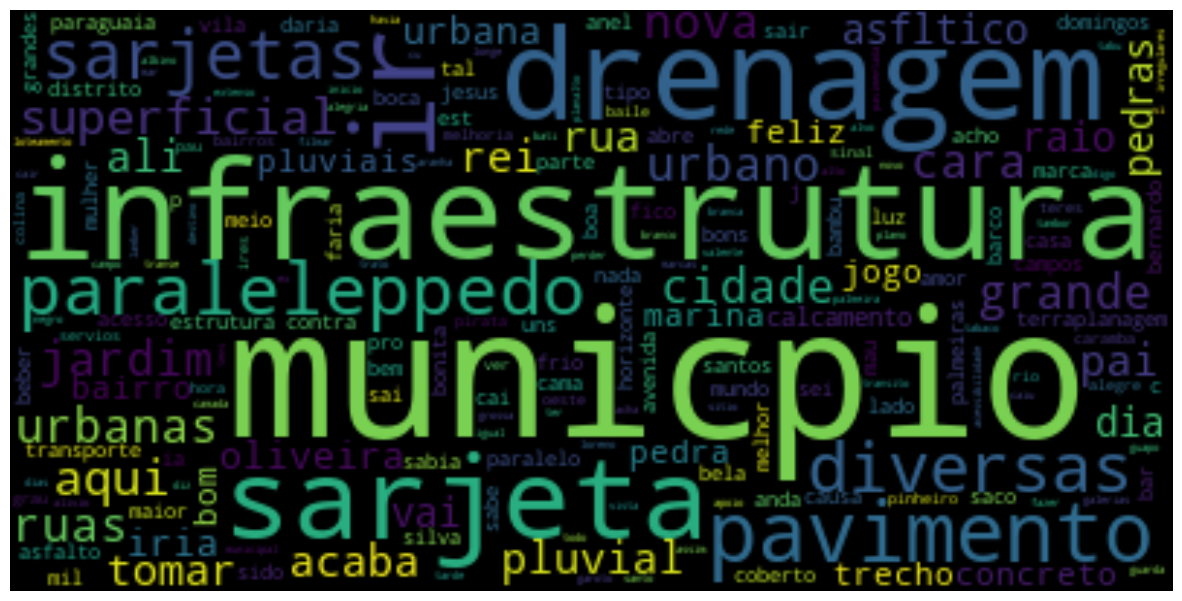

In [11]:
wordcloud = WordCloud()

contagem_dict = dict(zip(df_salvo['aux_palavras'].value_counts().index, df_salvo['aux_palavras'].value_counts().values))
# print(contagem_dict)

wordcloud.generate_from_frequencies(frequencies = contagem_dict)
plt.figure(figsize = (15, 10)) # tamanho do gráfico
plt.imshow(wordcloud, interpolation = 'bilinear') # plotagem da nuvem de palavras
plt.axis('off') # remove as bordas
plt.show() # mostra a word cloud

# Códigos testados

In [12]:
df_empreend.head()

,cod_mdr,cod_operacao,cod_saci,cod_convenio_siafi,cod_ag_operador,origem,dsc_concedente,dsc_fonte,dsc_unidade,cod_proposta,...,mun_LATITUDE,mun_LONGITUDE,mun_ALTITUDE,mun_AREA,mun_codigo_adotado,uf_NOME_UF,Região,uf_REGIAO,Município,mun_coordenadas
0,1-38001,319910.0,38001.0,0.0,375658.0,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,...,-8.054,-34.881,4.0,217494.0,261160.0,PERNAMBUCO,NE,Nordeste,Recife,"-8.054,-34.881"
1,1-38002,319912.0,38002.0,0.0,375664.0,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,...,-8.054,-34.881,4.0,217494.0,261160.0,PERNAMBUCO,NE,Nordeste,Recife,"-8.054,-34.881"
2,1-38003,319914.0,38003.0,0.0,375666.0,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,...,-8.054,-34.881,4.0,217494.0,261160.0,PERNAMBUCO,NE,Nordeste,Recife,"-8.054,-34.881"
3,1-38004,354485.0,38004.0,0.0,NaN,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1-38005,345051.0,38005.0,0.0,377438.0,PAC_MCID,MINISTERIO DAS CIDADES,FIN,SEMOB,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,SE,Sudeste,NaN,NaN


In [13]:
contagem  = df_empreend.empreendimento.str.split().explode('empreendimento').apply(lambda x: remover_simbolos_numeros_stopwords(x)).value_counts()
contagem

                244566
pavimentacao     22514
pavimentao       21693
municpio         16890
ruas             16146
                 ...  
gransotto            1
odacir               1
amboni               1
rotulana             1
aqusicao             1
Name: empreendimento, Length: 27732, dtype: int64

## Técnica Fuzzy de proximidade de palavras

Técnica que aplica conceitos de Fuzzy para agrupar palavras.

Retorna o grupo de palavras com o nome de grupo como chave e as frases que encontrou como pertencentes a esse grupo numa lista

 mais detalhes pode ser obtido em

 - https://github.com/seatgeek/fuzzywuzzy

### Exemplo com 100 linhas de empreendimentos

In [14]:
##codigo para agrupar nomes parecidos de empreendimentos
agrupados = agrupar_nomes(df_empreend.empreendimento.unique()[:100])
agrupados

{"IMPLANTACAO DO TRANSPORTE RAPIDO POR ONIBUS NO CORREDOR DA  'V CAXANGA ATE O TERMINAL DE CAMARAGIBE": ["IMPLANTACAO DO TRANSPORTE RAPIDO POR ONIBUS NO CORREDOR DA  'V CAXANGA ATE O TERMINAL DE CAMARAGIBE"],
 'CONSTRUCAO DO TERMINAL DE COSME E DAMIAO': ['CONSTRUCAO DO TERMINAL DE COSME E DAMIAO'],
 'IMPLANTA«ŸO DO TRANSPORTE RAPIDO POR ONIBUS NO CORREDOR     NORTE SUL NO TRECHO IGARASSU/JOANA BEZERRA/CENTRO DO RECIFE': ['IMPLANTA«ŸO DO TRANSPORTE RAPIDO POR ONIBUS NO CORREDOR     NORTE SUL NO TRECHO IGARASSU/JOANA BEZERRA/CENTRO DO RECIFE'],
 'NAN': ['NAN'],
 'PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS, COM INSERCAO DEDRENAGEM, GUIAS E SARJ. E CALCAMENTOS NO VERDE PARQUE': ['PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS, COM INSERCAO DEDRENAGEM, GUIAS E SARJ. E CALCAMENTOS NO VERDE PARQUE'],
 'PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS COM DRENAGEM,   GUIAS, SARJETAS E CALCAMENTO NO JARDIM DAS OLIVEIRAS': ['PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS COM DRENAGEM,   GUIAS, SARJETAS E 

Mostrando o tamanho de cada grupo encontrado

Nessa amostra com apenas 100 linhas da base, encontrou apenas 1 elemento em cada grupo

In [15]:
chaves = list(agrupados.keys())
for k in range(len(chaves)):
    print(f'Tamanho do grupo {k}: {len(agrupados[chaves[k]])}')
# 

Tamanho do grupo 0: 1
Tamanho do grupo 1: 1
Tamanho do grupo 2: 1
Tamanho do grupo 3: 1
Tamanho do grupo 4: 1
Tamanho do grupo 5: 1
Tamanho do grupo 6: 1
Tamanho do grupo 7: 1
Tamanho do grupo 8: 1
Tamanho do grupo 9: 1
Tamanho do grupo 10: 1
Tamanho do grupo 11: 1
Tamanho do grupo 12: 1
Tamanho do grupo 13: 1
Tamanho do grupo 14: 1
Tamanho do grupo 15: 1
Tamanho do grupo 16: 1
Tamanho do grupo 17: 1
Tamanho do grupo 18: 1
Tamanho do grupo 19: 1
Tamanho do grupo 20: 1
Tamanho do grupo 21: 1
Tamanho do grupo 22: 1
Tamanho do grupo 23: 1
Tamanho do grupo 24: 1
Tamanho do grupo 25: 1
Tamanho do grupo 26: 1
Tamanho do grupo 27: 1
Tamanho do grupo 28: 1
Tamanho do grupo 29: 1
Tamanho do grupo 30: 1
Tamanho do grupo 31: 1
Tamanho do grupo 32: 1
Tamanho do grupo 33: 1
Tamanho do grupo 34: 1
Tamanho do grupo 35: 1
Tamanho do grupo 36: 1
Tamanho do grupo 37: 1
Tamanho do grupo 38: 1
Tamanho do grupo 39: 1
Tamanho do grupo 40: 1
Tamanho do grupo 41: 1
Tamanho do grupo 42: 1
Tamanho do grupo 43: 

Tamanho maximo nos grupos

In [16]:
max([len(agrupados[k]) for k in agrupados.keys()])

1

## Técnica de clusterização com o algoritmo HDBSCAN e um vetorizador (transformação de textos para números)


HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de agrupamento que estende o DBSCAN para lidar com dados de forma mais flexível e eficaz. Assim como o DBSCAN, o HDBSCAN agrupa pontos densamente conectados, mas é mais robusto na detecção de clusters de diferentes densidades. O algoritmo constrói uma hierarquia de clusters utilizando uma técnica chamada árvore de agrupamento condensada, permitindo a extração de clusters em diferentes níveis de granularidade. Além disso, identifica pontos de ruído (outliers) de maneira mais eficaz, possibilitando a detecção de estruturas de dados mais complexas.

Uma das grandes vantagens do HDBSCAN é que não requer a definição prévia do número de clusters, diferentemente de algoritmos como K-means. O HDBSCAN determina automaticamente o número adequado de clusters com base na densidade dos dados, permitindo a identificação de clusters de diferentes formas e tamanhos. Isso o torna particularmente adequado para conjuntos de dados com estruturas complexas e irregulares. Em resumo, o HDBSCAN é uma ferramenta poderosa e flexível para análise de clusters, especialmente útil em situações onde os clusters têm densidades variadas e formas não esféricas.

Mais detalhes de implementação podem ser consultados na documentação:

- https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

### Usando como Vetorizador o modelo TfidfVectorizer 

O TfidfVectorizer é uma ferramenta amplamente utilizada em processamento de linguagem natural (PLN) e análise de texto para transformar uma coleção de documentos de texto em uma matriz de características numéricas, onde os valores representam a relevância de termos dentro de um documento, ponderados pela frequência do termo em relação a todos os documentos.

O TfidfVectorizer baseia-se no conceito de TF-IDF, que é um acrônimo para Term Frequency-Inverse Document Frequency (Frequência do Termo-Inversa Frequência no Documento).

Mais detalhes do algoritmo pode ser consultado em:

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer


In [17]:
empreendimentos = df_empreend.empreendimento[:1000]

Exemplo com 1000 linhas

O algoritmo agrupa em clusters de frases e as que não encontrou coloca no cluster -1

Embora tenha conseguido agrupar algumas palavras que façam sentido nesse exemplo, sobram mais da metade dos dados no cluster de ruído (-1) quando executado com todos os dados.

In [19]:


# Supondo que 'empreendimentos' é a sua lista de frases
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(empreendimentos)

# Redução de dimensionalidade
svd = TruncatedSVD(n_components=50)  # Ajuste n_components conforme necessário
X_reduced = svd.fit_transform(X)

# Clusterização com HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=50, metric='euclidean')
cluster_labels = clusterer.fit_predict(X_reduced)

df_frases = pd.DataFrame({'frase': empreendimentos, 'cluster': cluster_labels})

for cluster in set(cluster_labels):
    if cluster == -1:
        continue  # -1 é o cluster de ruído em HDBSCAN
    print(f"Cluster {cluster}:")
    for frase in df_frases[df_frases['cluster'] == cluster]['frase']:
        print(f"  {frase}")
    print("\n")

df_frases

Cluster 0:
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN
  NAN

,frase,cluster
0,IMPLANTACAO DO TRANSPORTE RAPIDO POR ONIBUS NO...,1
1,CONSTRUCAO DO TERMINAL DE COSME E DAMIAO,1
2,IMPLANTA«ŸO DO TRANSPORTE RAPIDO POR ONIBUS NO...,1
3,NAN,0
4,"PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS, C...",1
...,...,...
995,PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS - ...,1
996,NAN,0
997,PAVIMENTAÇÃO AFALTICA,1
998,PAVIMENTAÇÃO E QUALIFICAÇÃO DAS VIAS URBANAS D...,1


### Usando como Vetorizador o usado no modelo do Distilbert

Distilbert é um modelo destilado (mais básico) do modelo de linguagem BERT da Google, que inclui a parte inicial de vetorização e o modelo de linguem propriamente dito, o qual estamos usando apenas a parte inicial do mesmo.

Mais informações sobre o modelo pode ser obtida em:
- https://huggingface.co/docs/transformers/model_doc/distilbert

exemplo com 100 linhas da base por conta do processamento necessário ser alto

In [21]:
empreendimentos = df_empreend.empreendimento[:100]

In [22]:
# Inicializando o tokenizer e o modelo DistilBERT usando AutoTokenizer e AutoModel
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

# Criar DataLoader
dataset = SentenceDataset(empreendimentos, tokenizer)
batch_size = 16  # Ajuste o batch_size conforme necessário
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#descomentar se esiver usando no colab ou com GPU disponível
# Movendo o modelo para a GPU, se disponível
# device = device("cuda" if cuda.is_available() else "cpu")
# model.to(device)

# Obtendo os embeddings das sentenças
embeddings = get_embeddings(dataloader, model)
embeddings_array = embeddings.numpy()


In [23]:


# Redução de dimensionalidade
svd = TruncatedSVD(n_components=50)  # Ajuste n_components conforme necessário
embeddings_reduced = svd.fit_transform(embeddings_array)


In [24]:
# Ajuste dos parâmetros de HDBSCAN para obter menos clusters
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20, metric='euclidean')
cluster_labels = clusterer.fit_predict(embeddings_reduced)

df_sentencas = pd.DataFrame({'sentenca': empreendimentos, 'cluster': cluster_labels})

In [25]:
for cluster in set(cluster_labels):
    if cluster == -1:
        continue  # -1 é o cluster de ruído em HDBSCAN
    print(f"Cluster {cluster}:")
    for sentenca in df_sentencas[df_sentencas['cluster'] == cluster]['sentenca']:
        print(f"  {sentenca}")
    print("\n")

df_sentencas


Cluster 0:
  IMPLANTACAO DO TRANSPORTE RAPIDO POR ONIBUS NO CORREDOR DA  'V CAXANGA ATE O TERMINAL DE CAMARAGIBE
  CONSTRUCAO DO TERMINAL DE COSME E DAMIAO
  IMPLANTA«ŸO DO TRANSPORTE RAPIDO POR ONIBUS NO CORREDOR     NORTE SUL NO TRECHO IGARASSU/JOANA BEZERRA/CENTRO DO RECIFE
  PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS, COM INSERCAO DEDRENAGEM, GUIAS E SARJ. E CALCAMENTOS NO VERDE PARQUE
  PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS COM DRENAGEM,   GUIAS, SARJETAS E CALCAMENTO NO JARDIM DAS OLIVEIRAS
  PAVIMENTACAO ASFALTICA EM DIVERSAS RUAS E BAIRROS DA CIDADE
  PRO. TRANSPORTE - PAVIMENTACAO - SAO JOSE - LOT. BENJAMIN   PZO.1ŒDESEMBOLSO: JAN/2013 - PZO.ULTIMO DESEMBOLSO: MAR/2016
  SIM - SISTEMA INTEGRADO DE MONITORAMENTO.CONJUNTO DE INTER  VENCOES PARA CONTROLE DE TRAFEGO EM AREA
  IMPLANTACO DO CORREDOR AVENIDA TRONCO/CRUZEIRO DO SUL
  IMPLANTACAO DO CORREDOR PADRE CACIQUE/AVENIDA BEIRA RIO     (AV. EDVALDO PEREIRA PAIVA)
  PRO. TRANSPORTE - PAV. - NAVEGANTES I MEIA PRAIA (CONCL

,sentenca,cluster
0,IMPLANTACAO DO TRANSPORTE RAPIDO POR ONIBUS NO...,0
1,CONSTRUCAO DO TERMINAL DE COSME E DAMIAO,0
2,IMPLANTA«ŸO DO TRANSPORTE RAPIDO POR ONIBUS NO...,0
3,NAN,1
4,"PAVIMENTACAO E QUALIFICACAO DE VIAS URBANAS, C...",0
...,...,...
95,NAN,2
96,"PAVMTCAO E RECAP VIAS,AMPLIAC REDE DREN PLUV,E...",0
97,NAN,2
98,NAN,2


Novamente, o algoritmo hdbscan implementado agrupa em alguns clusters e no cluster (-1) coloca o ruído, ou tudo que sobra, o qual sobram muitas frases quando executado com todos os dados

## Código corretor de erros

Quebra as frases de empreendimentos em palavras soltas, para cada palavra será feito a tentativa de correção da palavra por um corretor de texto.

Mais detalhes em como o algoritmo funciona pode ser consultado em:
- https://pyspellchecker.readthedocs.io/en/latest/

In [26]:
empreendimentos = df_empreend[['empreendimento']]

df = df_empreend[['empreendimento']].copy().dropna()
df = df[df['empreendimento'] != "NAN"].reset_index(drop=True)
df['empreendimentos_limpos'] = df['empreendimento'].apply(remover_simbolos_numeros_stopwords)
df['palavras'] = df['empreendimentos_limpos'].str.split()

df_exploded = df.explode('palavras')[:300]
palavras_unicas = df_exploded['palavras'].unique()#.tolist()
df_palavras_unicas = df_exploded[['palavras']].drop_duplicates()
df_palavras_unicas

,palavras
0,implantacao
0,transporte
0,rapido
0,onibus
0,corredor
...,...
35,bgravata
35,dez
35,ultimo
36,protransporteacoes


In [35]:
# Inicializar o corretor ortográfico para português
spell = SpellChecker(language='pt')

#Transforma para dataframe do dask que é mais performático
ddf = dd.from_pandas(df_palavras_unicas, npartitions=cpu_count())
# with ProgressBar():
ddf['palavras_corrigidas'] = ddf['palavras'].map(corrigir_palavra, meta=('palavras_corrigidas', 'object'))
df_final = ddf.compute()
df_final


,palavras,palavras_corrigidas
0,implantacao,implantado
0,transporte,transporte
0,rapido,rápido
0,onibus,ónibus
0,corredor,corredor
...,...,...
35,bgravata,gravata
35,dez,dez
35,ultimo,ultimo
36,protransporteacoes,protransporteacoes
